In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import keras 
from  keras import layers, models

In [2]:
if tf.test.gpu_device_name():
    print('GPU available:', tf.test.gpu_device_name())
    
else:
    print("No GPU available. Please make sure you have TensorFlow configured to use GPU.")

GPU available: /device:GPU:0


In [3]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    for gpu in gpus:
        tf.config.experimental.set_memory_growth(gpu, True)

In [4]:
path = "D:\Cuong\ML\Data\emotional.csv"

In [5]:
import pandas as pd
import csv

data = pd.read_csv(path)

In [6]:
np.shape(data)

(35887, 3)

In [7]:
data.head()

,emotion,pixels,Usage
0,0,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...,Training
1,0,151 150 147 155 148 133 111 140 170 174 182 15...,Training
2,2,231 212 156 164 174 138 161 173 182 200 106 38...,Training
3,4,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...,Training
4,6,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...,Training


In [8]:
data.Usage.value_counts()

Usage
Training       28709
PublicTest      3589
PrivateTest     3589
Name: count, dtype: int64

In [9]:
#check target labels
emotion_map = {0: 'Angry', 1: 'Digust', 2: 'Fear', 3: 'Happy', 4: 'Sad', 5: 'Surprise', 6: 'Neutral'}
emotion_counts = data['emotion'].value_counts(sort=False).reset_index()
emotion_counts.columns = ['emotion', 'number']
emotion_counts['emotion'] = emotion_counts['emotion'].map(emotion_map)
emotion_counts

,emotion,number
0,Angry,4953
1,Fear,5121
2,Sad,6077
3,Neutral,6198
4,Happy,8989
5,Surprise,4002
6,Digust,547


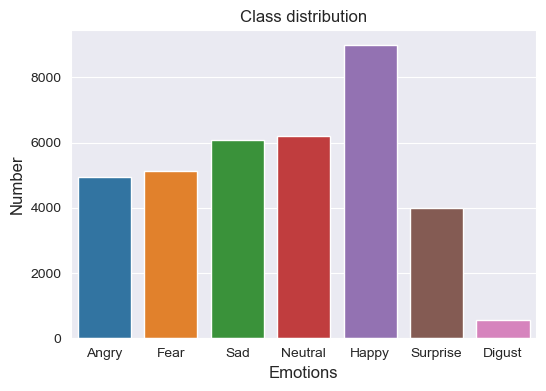

In [10]:
import seaborn as sns
# Plotting a bar graph of the class distributions
plt.figure(figsize=(6,4))
sns.barplot(x = emotion_counts.emotion,y= emotion_counts.number)
plt.title('Class distribution')
plt.ylabel('Number', fontsize=12)
plt.xlabel('Emotions', fontsize=12)
plt.show()

In [11]:
#initilize parameters
num_classes = 7 
width, height = 48, 48
num_epochs = 1
batch_size = 64
num_features = 64

In [12]:
#split data into training, validation and test set
data_train = data[data['Usage']=='Training'].copy()
data_val   = data[data['Usage']=='PublicTest'].copy()
data_test  = data[data['Usage']=='PrivateTest'].copy()
print("train shape: {}, \nvalidation shape: {}, \ntest shape: {}".format(data_train.shape, data_val.shape, data_test.shape))

train shape: (28709, 3), 
validation shape: (3589, 3), 
test shape: (3589, 3)


In [13]:
from keras.utils import to_categorical


# CRNO stands for Convert, Reshape, Normalize, One-hot encoding
# (i) convert strings to lists of integers
# (ii) reshape and normalise grayscale image with 255.0
# (iii) one-hot encoding label, e.g. class 3 to [0,0,0,1,0,0,0]

def CRNO(df, dataName):
    df['pixels'] = df['pixels'].apply(lambda pixel_sequence: [int(pixel) for pixel in pixel_sequence.split()])
    data_X = np.array(df['pixels'].tolist(), dtype='float32').reshape(-1,width, height,1)/255.0   
    data_Y = to_categorical(df['emotion'], num_classes)  
    print(dataName, "_X shape: {}, ", dataName, "_Y shape: {}".format(data_X.shape, data_Y.shape))
    return data_X, data_Y

    
train_X, train_Y = CRNO(data_train, "train") #training data
val_X, val_Y     = CRNO(data_val, "val") #validation data
test_X, test_Y   = CRNO(data_test, "test") #test data

train _X shape: {},  train _Y shape: (28709, 48, 48, 1)
val _X shape: {},  val _Y shape: (3589, 48, 48, 1)
test _X shape: {},  test _Y shape: (3589, 48, 48, 1)


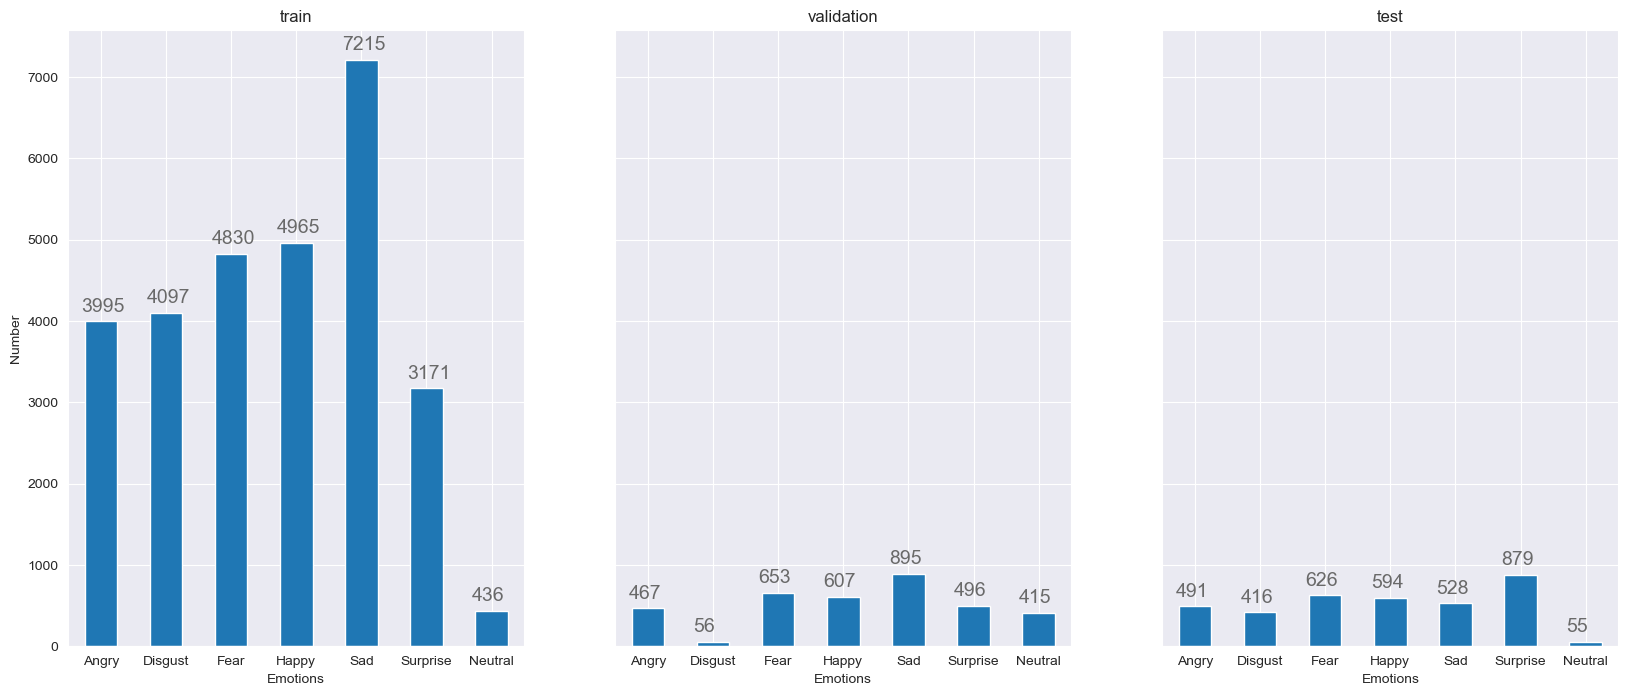

In [14]:
# barplot class distribution of train, val and test
emotion_labels = ['Angry', 'Disgust', 'Fear', 'Happy', 'Sad', 'Surprise', 'Neutral']

def setup_axe(axe,df,title):
    df['emotion'].value_counts(sort=False).plot(ax=axe, kind='bar', rot=0)
    axe.set_xticklabels(emotion_labels)
    axe.set_xlabel("Emotions")
    axe.set_ylabel("Number")
    axe.set_title(title)
    
    # set individual bar lables using above list
    for i in axe.patches:
        # get_x pulls left or right; get_height pushes up or down
        axe.text(i.get_x()-.05, i.get_height()+120, \
                str(round((i.get_height()), 2)), fontsize=14, color='dimgrey',
                    rotation=0)

   
fig, axes = plt.subplots(1,3, figsize=(20,8), sharey='all')
setup_axe(axes[0],data_train,'train')
setup_axe(axes[1],data_val,'validation')
setup_axe(axes[2],data_test,'test')
plt.show()

CNN model

In [15]:
from keras.optimizers import Adam
from keras import Sequential, layers
from keras.layers import Conv2D, Activation, BatchNormalization, MaxPooling2D, Flatten, Dense, Dropout, GlobalAveragePooling2D
def build_model():
    model = Sequential()
    
    #module 1
    model.add(Conv2D(2*2*num_features, kernel_size=(3, 3), input_shape=(width, height, 1), data_format='channels_last'))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(Conv2D(2*2*num_features, kernel_size=(3, 3), padding='same'))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
    
    #module 2
    model.add(Conv2D(2*num_features, kernel_size=(3, 3), padding='same'))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(Conv2D(2*num_features, kernel_size=(3, 3), padding='same'))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
    
    #module 3
    model.add(Conv2D(num_features, kernel_size=(3, 3), padding='same'))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(Conv2D(num_features, kernel_size=(3, 3), padding='same'))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
    
    #flatten
    model.add(Flatten())
    
    #dense 1
    model.add(Dense(2*2*2*num_features))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    
    #dense 2
    model.add(Dense(2*2*num_features))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    
    #dense 3
    model.add(Dense(2*num_features))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    
    #output layer
    model.add(Dense(num_classes, activation='softmax'))
    
    model.compile(loss='categorical_crossentropy', 
                  optimizer=Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-7), 
                  metrics=['accuracy'])
    
    return model

In [16]:
def self_build_model():
    model = Sequential()
    model.add(Conv2D(2*2*128, kernel_size=(3, 3), input_shape=(width, height, 1)))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(Conv2D(2*128, (1,1)))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(MaxPooling2D((2,2)))
    model.add(Conv2D(2*128, (3,3), padding="same"))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(BatchNormalization())
    model.add(Conv2D(128, (1,1)))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(MaxPooling2D((2,2)))
    model.add(BatchNormalization())
    model.add(Conv2D(128, (3,3), padding="same"))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(MaxPooling2D((2,2)))
    model.add(BatchNormalization())
    model.add(GlobalAveragePooling2D())
    model.add(Flatten())
    
    model.add(Dropout(0.5))
    
    model.add(Dense(128, activation='relu'))
    model.add(Dense(64, activation='relu'))
    model.add(Dense(32, activation='relu'))
    model.add(Dense(16, activation='relu'))
    model.add(Dense(8, activation='relu'))
    model.add(Dense(7, activation='softmax'))
    model.compile(loss='categorical_crossentropy', 
                  optimizer='adam', 
                  metrics=['accuracy'])
    return model

In [17]:
from keras.applications.efficientnet import EfficientNetB2
from keras.applications.efficientnet import preprocess_input
from glob import glob
from keras.models import Model

In [19]:
import os
checkpoint_path = "D:/Cuong/private/work/Python/Project/EmosionPredict/training6/cp-{epoch:04d}.h5"
checkpoint_dir = os.path.dirname(checkpoint_path)

In [ ]:
checkpoint_path = "training6/cp-{epoch:04d}.h5"

In [20]:
import math
n_batches = len(train_X) / batch_size
n_batches = math.ceil(n_batches)    # round up the number of batches to the nearest whole integer

# Create a callback that saves the model's weights every 5 epochs
cp_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_path, 
    verbose=1, 
    save_weights_only=True,
    save_freq=5*n_batches)

In [ ]:
model = self_build_model()
model.summary()
# Save the weights using the `checkpoint_path` format
model.save_weights(checkpoint_path.format(epoch=0))
# Train the model with the new callback
history = model.fit(train_X, 
          train_Y,
          epochs=10, 
          shuffle=True,
          batch_size=batch_size, 
          callbacks=[cp_callback],
          validation_data=(val_X, val_Y),
          verbose=0)

In [20]:
os.listdir(checkpoint_dir)

['checkpoint',
 'cp-0000.ckpt.data-00000-of-00001',
 'cp-0000.ckpt.index',
 'cp-0005.ckpt.data-00000-of-00001',
 'cp-0005.ckpt.index',
 'cp-0010.ckpt.data-00000-of-00001',
 'cp-0010.ckpt.index',
 'cp-0015.ckpt.data-00000-of-00001',
 'cp-0015.ckpt.index',
 'cp-0020.ckpt.data-00000-of-00001',
 'cp-0020.ckpt.index',
 'cp-0025.ckpt.data-00000-of-00001',
 'cp-0025.ckpt.index',
 'cp-0030.ckpt.data-00000-of-00001',
 'cp-0030.ckpt.index',
 'cp-0035.ckpt.data-00000-of-00001',
 'cp-0035.ckpt.index',
 'cp-0040.ckpt.data-00000-of-00001',
 'cp-0040.ckpt.index',
 'cp-0045.ckpt.data-00000-of-00001',
 'cp-0045.ckpt.index',
 'cp-0050.ckpt.data-00000-of-00001',
 'cp-0050.ckpt.index']

In [21]:
latest = tf.train.latest_checkpoint(checkpoint_dir)
#latest = 'D:/Cuong/private/work/Python/Project/EmosionPredict/training4\\cp-0050.ckpt'

In [22]:
# Create a new model instance
model = self_build_model()

# Load the previously saved weights
model.load_weights(latest)

# Re-evaluate the model
loss, acc = model.evaluate(test_X, test_Y, verbose=2)
print("Restored model, accuracy: {:5.2f}%".format(100 * acc))

113/113 - 3s - loss: 1.3045 - accuracy: 0.5564 - 3s/epoch - 29ms/step
Restored model, accuracy: 55.64%


24/12: 1,327,799 param - acc: 59.63%

Visualize training performance

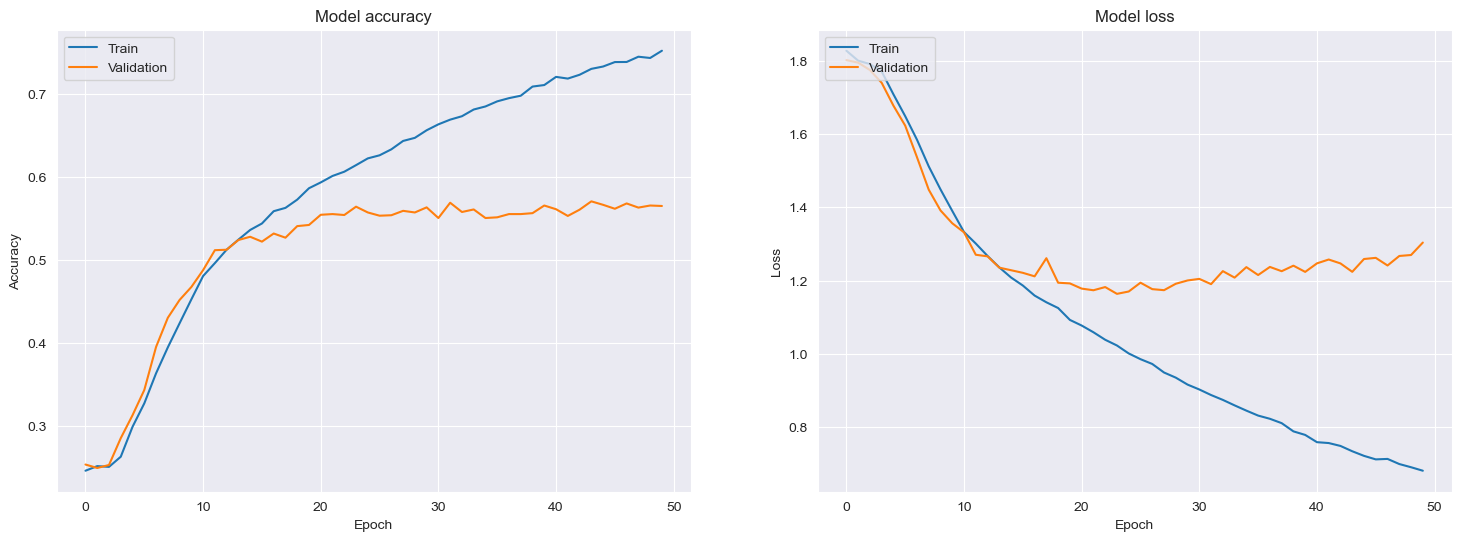

In [23]:
fig, axes = plt.subplots(1,2, figsize=(18, 6))
# Plot training & validation accuracy values
axes[0].plot(history.history['accuracy'])
axes[0].plot(history.history['val_accuracy'])
axes[0].set_title('Model accuracy')
axes[0].set_ylabel('Accuracy')
axes[0].set_xlabel('Epoch')
axes[0].legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
axes[1].plot(history.history['loss'])
axes[1].plot(history.history['val_loss'])
axes[1].set_title('Model loss')
axes[1].set_ylabel('Loss')
axes[1].set_xlabel('Epoch')
axes[1].legend(['Train', 'Validation'], loc='upper left')
plt.show()